In [1]:
!pip install kaggle -qq
!pip install dash -qq
!pip install gdown -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 14.1 MB/s eta 0:00:00


In [2]:
import dash
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import os
import json
import requests
import io
import gdown
import seaborn as sns

from matplotlib import pyplot as plt
from scipy import stats
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go
from dash import dash_table

In [3]:
config_dir = '/root/.config/kaggle'
os.makedirs(config_dir, exist_ok=True)

kaggle_json = {
    "username": "ckcchamp",
    "key": "438acc2af14cd41abba475f675733b38"
}
kaggle_json_path = os.path.join(config_dir, 'kaggle.json')
with open(kaggle_json_path, 'w') as f:
    json.dump(kaggle_json, f)
os.chmod(kaggle_json_path, 0o600)

In [4]:
import kaggle

In [5]:
kaggle.api.authenticate()

In [6]:
kaggle.api.dataset_download_files('dtrade84/madden-24-player-ratings',path= '.',unzip=True)
kaggle.api.dataset_download_files('reinerjasin/nba-2k25-player-complete-dataset',path= '.',unzip=True)
kaggle.api.dataset_download_files('rajatsurana979/fifafcmobile24',path= '.',unzip=True)

Dataset URL: https://www.kaggle.com/datasets/dtrade84/madden-24-player-ratings
Dataset URL: https://www.kaggle.com/datasets/reinerjasin/nba-2k25-player-complete-dataset
Dataset URL: https://www.kaggle.com/datasets/rajatsurana979/fifafcmobile24


In [7]:
url = 'https://drive.google.com/uc?export=download&id=1Rlz_djH1iBp6t4GbEPP8UJzE2-Kmh5nH'
gdown.download(url, 'nfl_salary.xlsx')

Downloading...
From: https://drive.google.com/uc?export=download&id=1Rlz_djH1iBp6t4GbEPP8UJzE2-Kmh5nH
To: /content/nfl_salary.xlsx
100%|██████████| 431k/431k [00:00<00:00, 44.9MB/s]


'nfl_salary.xlsx'

In [8]:
nfl_salary_raw = pd.read_excel('nfl_salary.xlsx')
nfl_raw = pd.read_csv('maddennfl24fullplayerratings.csv')
nba_raw = pd.read_csv('current_nba_players.csv')
fifa_raw = pd.read_csv('male_players.csv')

In [11]:
def feet_inches_to_cm(height_str):
    try:
        if pd.isna(height_str):
            return None
        height_str = str(height_str).replace(' ', '').replace('"', '')
        parts = height_str.split("'")
        feet = float(parts[0])
        inches = float(parts[1]) if len(parts) > 1 and parts[1] else 0
        total_inches = feet * 12 + inches
        cm = total_inches * 2.54
        return round(cm)
    except:
        return None

In [12]:
def lbs_to_kg(weight_lbs):
    if pd.isna(weight_lbs):
            return None
    weight = pd.to_numeric(weight_lbs, errors='coerce')
    if pd.isna(weight):
            return None
    weight_kg = weight * 0.45359237
    return round(weight_kg)

In [13]:
def inches_to_cm(Height):
    if pd.isna(Height):
            return None
    Height = pd.to_numeric(Height, errors='coerce')
    if pd.isna(Height):
            return None
    height_cm = Height * 2.54
    return round(height_cm)

In [18]:
nfl = nfl_raw[['Full Name', 'Overall Rating', 'Height','Years Pro', 'Weight', 'Age']]
nfl = nfl.merge(
    nfl_salary_raw,
    left_on='Full Name',
    right_on='Player',
    how='inner')

if not pd.api.types.is_numeric_dtype(nfl['APY']):
    nfl['APY'] = nfl['APY'].replace('[\$,]', '', regex=True).astype(float)
nfl.sort_values('APY', ascending=False, inplace=True)
nfl.drop_duplicates('Full Name', keep='first', inplace=True)
nfl=nfl[['Full Name', 'Overall Rating', 'Height', 'Weight', 'Age','Years Pro', 'Pos.', 'APY']]
nfl

,Full Name,Overall Rating,Height,Weight,Age,Years Pro,Pos.,APY
752,Dak Prescott,87,74,238,30,7,QB,60000000.0
589,Joe Burrow,95,76,215,26,3,QB,55000000.0
1488,Jordan Love,70,76,219,24,3,QB,55000000.0
249,Trevor Lawrence,82,78,220,23,2,QB,55000000.0
16,Tua Tagovailoa,83,73,217,25,3,QB,53100000.0
...,...,...,...,...,...,...,...,...
885,Ian Book,55,72,206,25,2,QB,225000.0
819,Ochaun Mathis,64,76,247,24,0,EDGE,225000.0
1433,Kyle Philips,71,71,189,24,1,WR,225000.0
769,Charles Harris,71,75,250,28,6,EDGE,225000.0


In [19]:
nfl['height_cm'] = nfl['Height'].apply(inches_to_cm)
nfl['weight_kg'] = nfl['Weight'].apply(lbs_to_kg)
nfl.drop(['Height', 'Weight'], axis=1, inplace=True)
nfl.rename(columns={'Full Name': 'name', 'Overall Rating': 'overall', 'Years Pro': 'years_pro', 'Pos.': 'position'}, inplace=True)
nfl= nfl[['name', 'overall', 'height_cm', 'weight_kg', 'Age', 'years_pro', 'position', 'APY']]
nfl

,name,overall,height_cm,weight_kg,Age,years_pro,position,APY
752,Dak Prescott,87,188,108,30,7,QB,60000000.0
589,Joe Burrow,95,193,98,26,3,QB,55000000.0
1488,Jordan Love,70,193,99,24,3,QB,55000000.0
249,Trevor Lawrence,82,198,100,23,2,QB,55000000.0
16,Tua Tagovailoa,83,185,98,25,3,QB,53100000.0
...,...,...,...,...,...,...,...,...
885,Ian Book,55,183,93,25,2,QB,225000.0
819,Ochaun Mathis,64,193,112,24,0,EDGE,225000.0
1433,Kyle Philips,71,180,86,24,1,WR,225000.0
769,Charles Harris,71,190,113,28,6,EDGE,225000.0


In [20]:
target_date = pd.to_datetime('2024-08-30')
nba_raw['Age'] = pd.to_datetime(nba_raw['birthdate'], errors='coerce').apply(
    lambda x: relativedelta(target_date, x).years if pd.notnull(x) else None)
nba = nba_raw[['name', 'overall','height_feet', 'weight_lbs', 'Age','years_in_the_nba', 'position_1', 'season_salary']]
nba

,name,overall,height_feet,weight_lbs,Age,years_in_the_nba,position_1,season_salary
0,Aaron Gordon,85,"6'8""",235,28,11.0,PF,22841455.0
1,Aaron Holiday,74,"6'0""",185,27,7.0,PG,4668000.0
2,Aaron Nesmith,79,"6'5""",215,24,5.0,SF,11000000.0
3,Aaron Wiggins,79,"6'5""",190,25,4.0,PF,10514017.0
4,Adam Flagler,67,"6'3""",180,24,2.0,SG,NaN
...,...,...,...,...,...,...,...,...
521,Zach Edey,79,"7'5""",305,22,1.0,C,5756880.0
522,Zach LaVine,85,"6'5""",200,29,11.0,SG,43031940.0
523,Zeke Nnaji,72,"6'9""",240,23,5.0,C,8888889.0
524,Ziaire Williams,76,"6'9""",185,22,4.0,SF,6133005.0


In [21]:
nba['height_cm'] = nba['height_feet'].apply(feet_inches_to_cm)
nba['weight_kg'] = nba['weight_lbs'].apply(lbs_to_kg)
nba['APY']=nba['season_salary']
nba.drop(['height_feet', 'weight_lbs','season_salary'], axis=1, inplace=True)
nba.dropna(subset=['APY'], inplace=True)
nba.rename(columns={'Full Name': 'name', 'years_in_the_nba': 'years_pro', 'position_1': 'position'}, inplace=True)
nba= nba[['name', 'overall', 'height_cm', 'weight_kg', 'Age', 'years_pro', 'position', 'APY']]
nba

<ipython-input-21-78ea1a2fa504>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba['height_cm'] = nba['height_feet'].apply(feet_inches_to_cm)
<ipython-input-21-78ea1a2fa504>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba['weight_kg'] = nba['weight_lbs'].apply(lbs_to_kg)
<ipython-input-21-78ea1a2fa504>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

,name,overall,height_cm,weight_kg,Age,years_pro,position,APY
0,Aaron Gordon,85,203,107,28,11.0,PF,22841455.0
1,Aaron Holiday,74,183,84,27,7.0,PG,4668000.0
2,Aaron Nesmith,79,196,98,24,5.0,SF,11000000.0
3,Aaron Wiggins,79,196,86,25,4.0,PF,10514017.0
7,A.J. Green,77,193,86,24,3.0,SG,2120693.0
...,...,...,...,...,...,...,...,...
521,Zach Edey,79,226,138,22,1.0,C,5756880.0
522,Zach LaVine,85,196,91,29,11.0,SG,43031940.0
523,Zeke Nnaji,72,206,109,23,5.0,C,8888889.0
524,Ziaire Williams,76,206,84,22,4.0,SF,6133005.0


In [22]:
fifa = fifa_raw[fifa_raw['fifa_version'] == 24][['long_name', 'overall', 'height_cm','weight_kg', 'age', 'league_level','player_positions', 'wage_eur']]
fifa.drop_duplicates('long_name', keep='first', inplace=True)
fifa = fifa[fifa['league_level'] == 1]
fifa['Age'] = fifa['age']
fifa.drop('age', axis=1, inplace=True)
fifa

,long_name,overall,height_cm,weight_kg,league_level,player_positions,wage_eur,Age
161671,Rúben Miguel Marques dos Santos Fernandes,71,187,81,1.0,CB,5000.0,37
161673,Cristiano Ronaldo dos Santos Aveiro,86,187,85,1.0,ST,66000.0,38
161674,Karl Tommy Andreas Johansson,65,184,78,1.0,CB,850.0,41
161675,José Manuel Reina Páez,77,188,92,1.0,GK,14000.0,40
161676,Roque Luis Santa Cruz Cantero,70,191,93,1.0,ST,500.0,41
...,...,...,...,...,...,...,...,...
180015,Umut Yaşar Keçeci,58,182,73,1.0,ST,2000.0,19
180016,Rakan Al Kaabi,54,174,71,1.0,"CDM, CM",2000.0,20
180018,Rodrigo Frutos,58,188,87,1.0,GK,500.0,20
180019,Christian Bos,55,180,70,1.0,RB,500.0,18


In [23]:
def wage_to_salary(wage_eur):
  return wage_eur*52

In [24]:
fifa['APY'] = fifa['wage_eur'].apply(wage_to_salary)
fifa.drop('wage_eur', axis=1, inplace=True)
fifa.rename(columns={'long_name': 'name',  'player_positions': 'position'}, inplace=True)
fifa= fifa[['name', 'overall', 'height_cm', 'weight_kg', 'Age', 'position', 'APY']]
fifa

,name,overall,height_cm,weight_kg,Age,position,APY
161671,Rúben Miguel Marques dos Santos Fernandes,71,187,81,37,CB,260000.0
161673,Cristiano Ronaldo dos Santos Aveiro,86,187,85,38,ST,3432000.0
161674,Karl Tommy Andreas Johansson,65,184,78,41,CB,44200.0
161675,José Manuel Reina Páez,77,188,92,40,GK,728000.0
161676,Roque Luis Santa Cruz Cantero,70,191,93,41,ST,26000.0
...,...,...,...,...,...,...,...
180015,Umut Yaşar Keçeci,58,182,73,19,ST,104000.0
180016,Rakan Al Kaabi,54,174,71,20,"CDM, CM",104000.0
180018,Rodrigo Frutos,58,188,87,20,GK,26000.0
180019,Christian Bos,55,180,70,18,RB,26000.0


In [25]:
nfl['sport'] = 'NFL'
nba['sport'] = 'NBA'
fifa['sport'] = 'FIFA'
all_data = pd.concat([nfl, nba, fifa], ignore_index=True)
all_data

<ipython-input-25-7b631a2a76e5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nfl['sport'] = 'NFL'
<ipython-input-25-7b631a2a76e5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba['sport'] = 'NBA'


,name,overall,height_cm,weight_kg,Age,years_pro,position,APY,sport
0,Dak Prescott,87,188,108,30,7.0,QB,60000000.0,NFL
1,Joe Burrow,95,193,98,26,3.0,QB,55000000.0,NFL
2,Jordan Love,70,193,99,24,3.0,QB,55000000.0,NFL
3,Trevor Lawrence,82,198,100,23,2.0,QB,55000000.0,NFL
4,Tua Tagovailoa,83,185,98,25,3.0,QB,53100000.0,NFL
...,...,...,...,...,...,...,...,...,...
15555,Umut Yaşar Keçeci,58,182,73,19,NaN,ST,104000.0,FIFA
15556,Rakan Al Kaabi,54,174,71,20,NaN,"CDM, CM",104000.0,FIFA
15557,Rodrigo Frutos,58,188,87,20,NaN,GK,26000.0,FIFA
15558,Christian Bos,55,180,70,18,NaN,RB,26000.0,FIFA


In [26]:
for sport in ['NFL', 'NBA', 'FIFA']:
    print(f"\nStats for {sport}:")
    sport_data = all_data[all_data['sport'] == sport]
    print(sport_data[['height_cm', 'weight_kg', 'Age', 'overall', 'APY']].describe().round(2))


Stats for NFL:
       height_cm  weight_kg      Age  overall          APY
count    1629.00    1629.00  1629.00  1629.00      1629.00
mean      188.51     111.22    25.67    71.13   4580632.31
std         6.79      21.52     2.90    10.03   7309696.80
min       168.00      73.00    20.00    26.00         0.00
25%       183.00      93.00    24.00    65.00   1039115.00
50%       188.00     107.00    25.00    70.00   1345702.00
75%       193.00     133.00    27.00    77.00   4365448.00
max       206.00     172.00    39.00    99.00  60000000.00

Stats for NBA:
       height_cm  weight_kg     Age  overall          APY
count     399.00     399.00  399.00   399.00       399.00
mean      199.91      97.63   25.89    78.20  12590740.68
std         8.02      10.64    4.58     6.06  12843565.18
min       183.00      73.00   19.00    68.00    600000.00
25%       196.00      91.00   22.00    74.00   2995020.00
50%       201.00      97.00   25.00    77.00   7723000.00
75%       206.00     104.00   2

In [27]:
def plot_physical_attributes(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    sns.boxplot(x='sport', y='height_cm', data=df, ax=ax1)
    ax1.set_title('Height Distribution by Sport')
    ax1.set_ylabel('Height (cm)')

    sns.boxplot(x='sport', y='weight_kg', data=df, ax=ax2)
    ax2.set_title('Weight Distribution by Sport')
    ax2.set_ylabel('Weight (kg)')

    plt.tight_layout()
    plt.show()

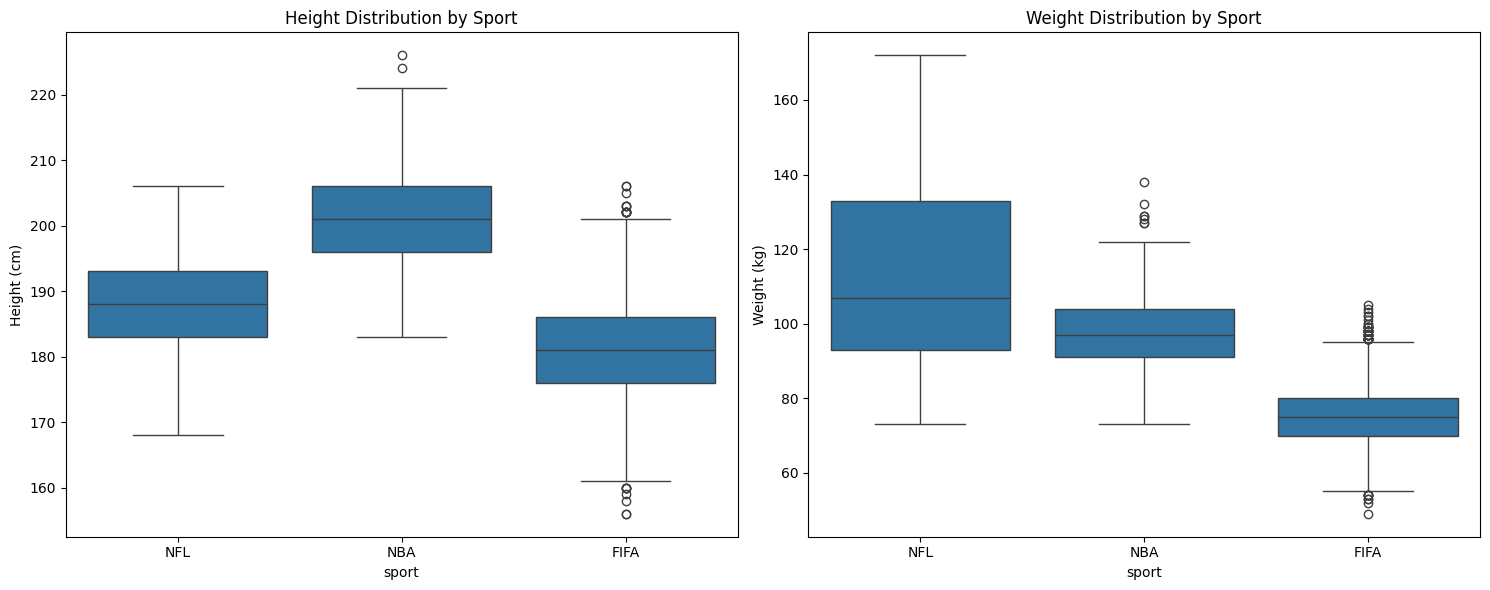

In [28]:
plot_physical_attributes(all_data)

In [29]:
def plot_salary_distribution(df):
    plt.figure(figsize=(12, 6))

    for sport in df['sport'].unique():
        sport_data = df[df['sport'] == sport]['APY']
        sns.kdeplot(data=np.log10(sport_data), label=sport)

    plt.title('Salary Distribution (Log Scale)')
    plt.xlabel('Log10(Annual Pay)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


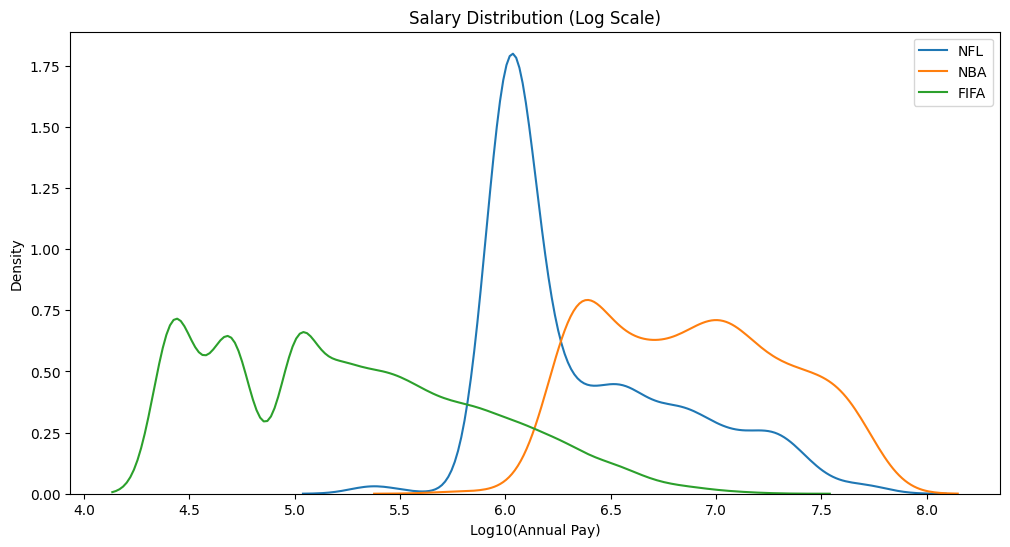

In [30]:
plot_salary_distribution(all_data)

In [31]:
def plot_performance_comparison(df):
    plt.figure(figsize=(10, 6))

    sns.violinplot(x='sport', y='overall', data=df)
    plt.title('Performance Ratings Distribution by Sport')
    plt.ylabel('Overall Rating')

    plt.show()

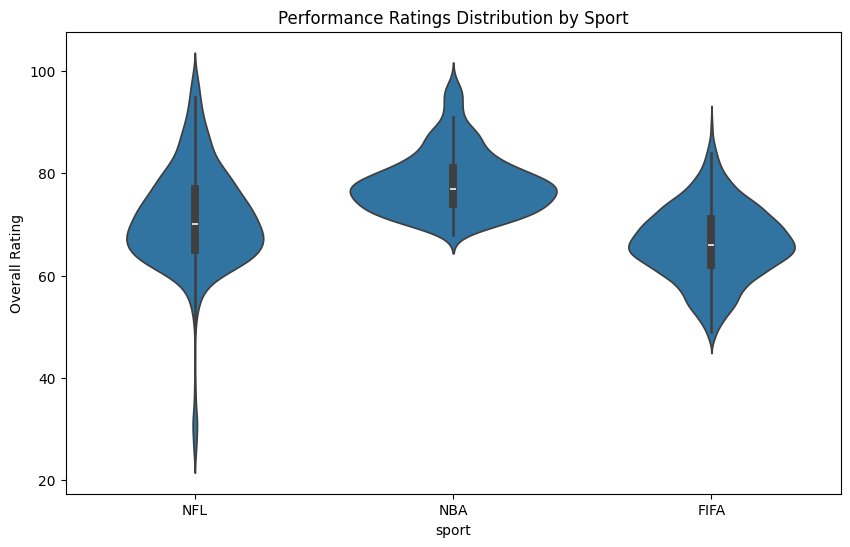

In [32]:
plot_performance_comparison(all_data)

In [33]:
def plot_age_experience_analysis(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    sns.boxplot(x='sport', y='Age', data=df, ax=ax1)
    ax1.set_title('Age Distribution by Sport')
    for sport in df['sport'].unique():
        sport_data = df[df['sport'] == sport]
        ax2.scatter(sport_data['years_pro'], np.log10(sport_data['APY']),
                   alpha=0.5, label=sport)

    ax2.set_title('Experience vs Salary')
    ax2.set_xlabel('Years Pro')
    ax2.set_ylabel('Log10(Annual Pay)')
    ax2.legend()
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


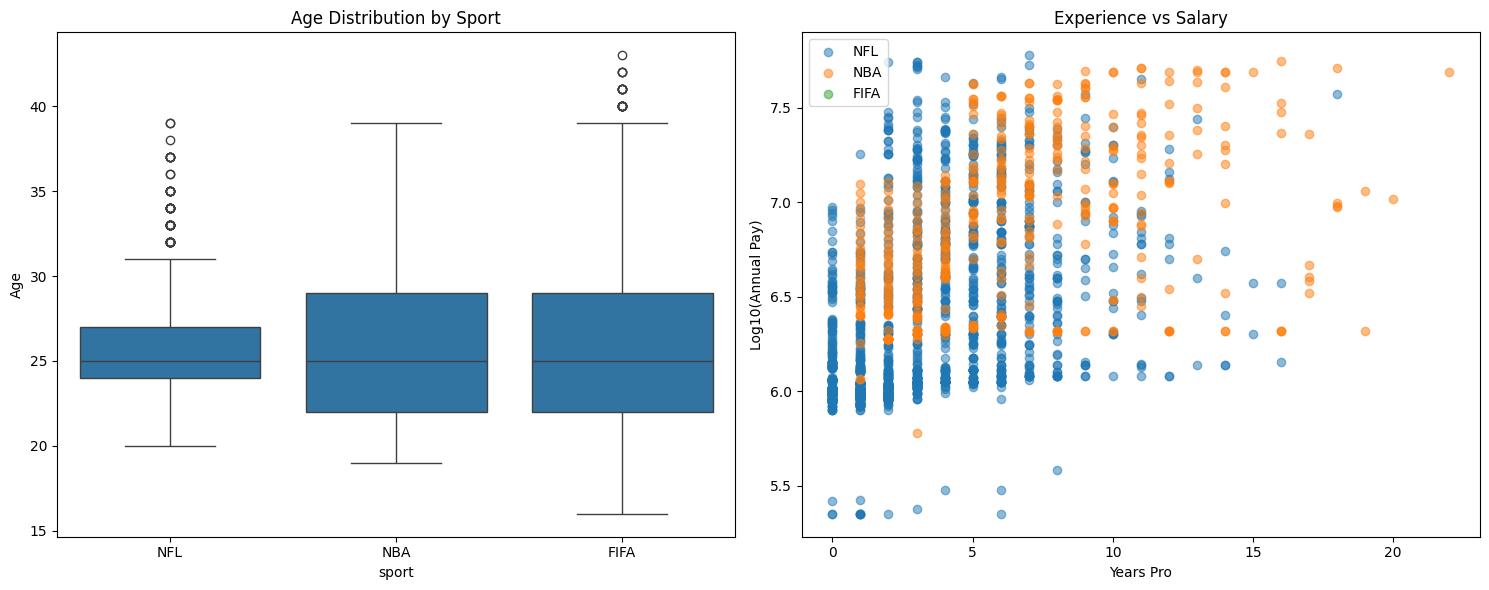

In [34]:
plot_age_experience_analysis(all_data)

In [35]:
def plot_correlation_matrix(df):
    numeric_cols = ['height_cm', 'weight_kg', 'Age', 'overall', 'APY']
    for sport in df['sport'].unique():
        plt.figure(figsize=(10, 8))
        sport_data = df[df['sport'] == sport][numeric_cols]
        corr = sport_data.corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title(f'Correlation Matrix - {sport}')
        plt.show()

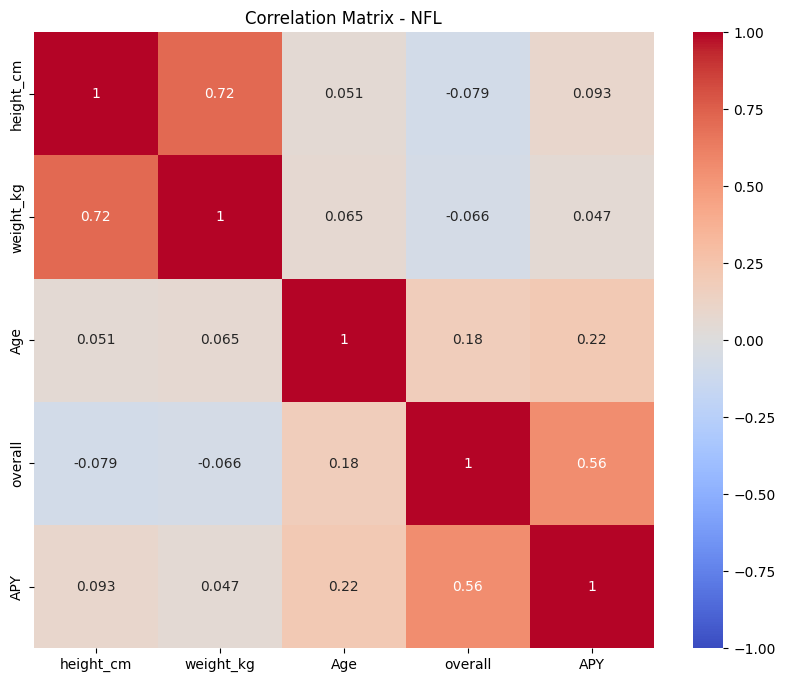

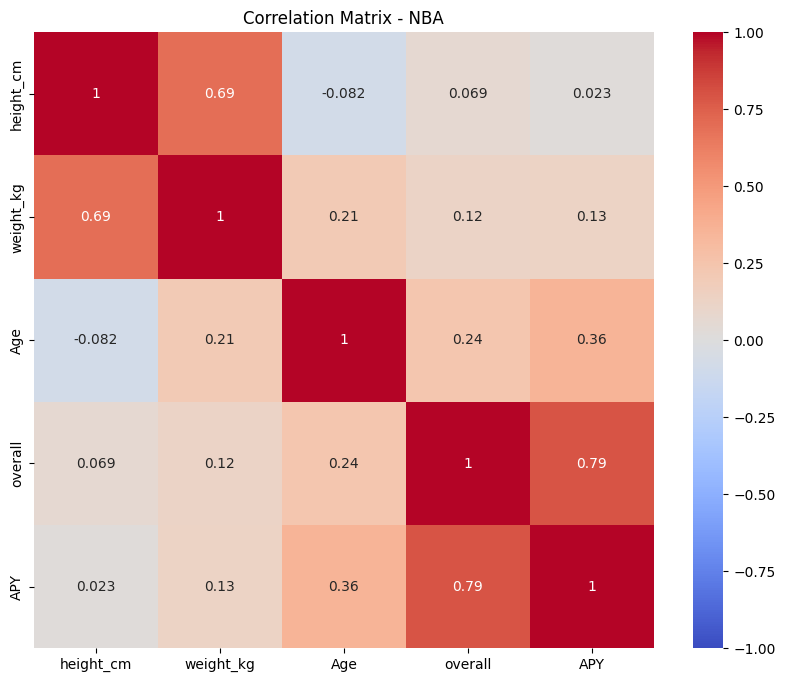

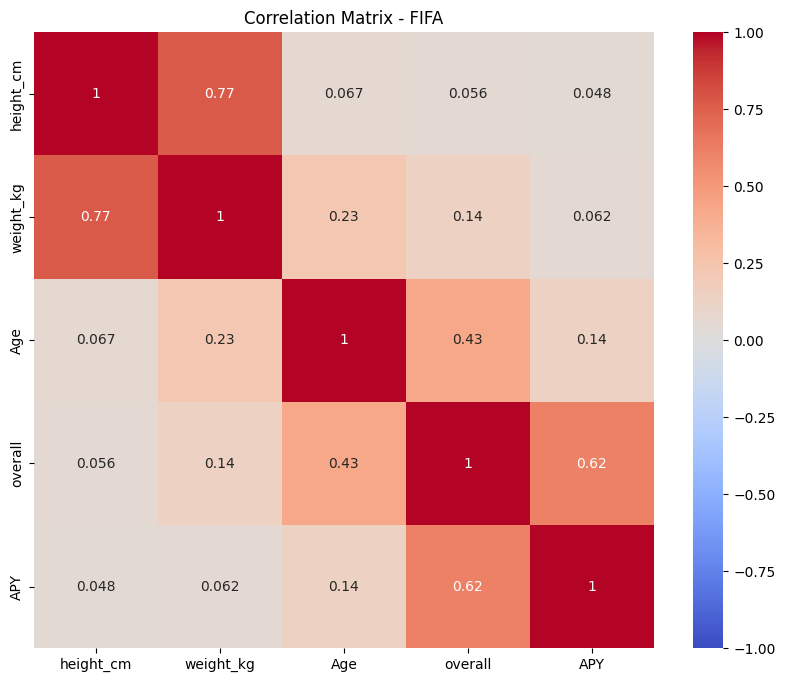

In [36]:
plot_correlation_matrix(all_data)

In [37]:
for sport in all_data['sport'].unique():
    print(f"\nTop 5 highest paid {sport} players:")
    top_players = all_data[all_data['sport'] == sport].nlargest(5, 'APY')
    print(top_players[['name', 'position', 'overall', 'APY']].to_string())



Top 5 highest paid NFL players:
              name position  overall         APY
0     Dak Prescott       QB       87  60000000.0
1       Joe Burrow       QB       95  55000000.0
2      Jordan Love       QB       70  55000000.0
3  Trevor Lawrence       QB       82  55000000.0
4   Tua Tagovailoa       QB       83  53100000.0

Top 5 highest paid NBA players:
               name position  overall         APY
1981  Stephen Curry       PG       95  55761216.0
1826    Joel Embiid        C       95  51415938.0
1928   Nikola Jokic        C       98  51415938.0
1863   Kevin Durant       PF       95  51179021.0
1664   Bradley Beal       SG       85  50203930.0

Top 5 highest paid FIFA players:
                                         name position  overall         APY
2642                          Kevin De Bruyne  CM, CAM       91  18200000.0
2423                       Robert Lewandowski       ST       90  17680000.0
7519                     Erling Braut Haaland       ST       91  17680000.0
74

In [38]:
for sport in all_data['sport'].unique():
    print(f"\nAverage metrics by position for {sport}:")
    pos_stats = all_data[all_data['sport'] == sport].groupby('position').agg({
        'height_cm': 'mean',
        'weight_kg': 'mean',
        'overall': 'mean',
        'APY': 'mean'
    }).round(2)
    print(pos_stats.to_string())


Average metrics by position for NFL:
          height_cm  weight_kg  overall          APY
position                                            
C            192.70     139.30    69.74   3606781.98
CB           182.77      87.53    72.77   3520621.92
EDGE         192.80     118.24    72.16   5398534.03
FB           185.00     112.78    73.78   2359340.78
IDL          191.50     138.59    70.67   4817768.16
K            184.15      89.15    76.12   3531333.94
LB           186.73     106.02    70.45   3158581.08
LG           194.28     142.49    69.77   3931481.58
LS           188.07     108.97    33.59   1280510.52
LT           197.34     141.98    71.51   6266131.67
P            188.33      96.74    76.00   2142484.70
QB           189.00      99.04    68.07  12452613.23
RB           179.21      96.31    74.01   2825595.50
RG           194.48     144.28    70.22   4406197.96
RT           197.80     144.39    70.62   5963886.44
S            183.28      92.09    72.88   3372319.38
TE      

In [39]:
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1('different between Sports'),

    html.Div([
        html.Label('X'),
        dcc.Dropdown(
            id='x-axis',
            options=[
                {'label': 'height(cm)', 'value': 'height_cm'},
                {'label': 'weight(kg)', 'value': 'weight_kg'},
                {'label': 'age', 'value': 'Age'},
                {'label': 'Overall', 'value': 'overall'},
                {'label': 'Salary', 'value': 'APY'}
            ],
            value='height_cm'
        ),

        html.Label('Y'),
        dcc.Dropdown(
            id='y-axis',
            options=[
                {'label': 'height(cm)', 'value': 'height_cm'},
                {'label': 'weight(kg)', 'value': 'weight_kg'},
                {'label': 'age', 'value': 'Age'},
                {'label': 'Overall', 'value': 'overall'},
                {'label': 'Salary', 'value': 'APY'}
            ],
            value='weight_kg'
        ),

        html.Label('Sport'),
        dcc.Checklist(
            id='sport-selector',
            options=[
                {'label': 'NFL', 'value': 'NFL'},
                {'label': 'NBA', 'value': 'NBA'},
                {'label': 'FIFA', 'value': 'FIFA'}
            ],
            value=['NFL', 'NBA', 'FIFA']
        )
    ]),

    # Graph
    dcc.Graph(id='scatter-plot')
])

# Callback to update the graph
@app.callback(
    Output('scatter-plot', 'figure'),
    [Input('x-axis', 'value'),
     Input('y-axis', 'value'),
     Input('sport-selector', 'value')]
)
def update_graph(x_axis, y_axis, selected_sports):
    filtered_data = all_data[all_data['sport'].isin(selected_sports)]

    fig = px.scatter(
        filtered_data,
        x=x_axis,
        y=y_axis,
        color='sport',
        hover_data=['name', 'position', 'Age', 'overall', 'APY'],
        title=f' {x_axis} vs {y_axis}'
    )

    if x_axis == 'APY':
        fig.update_xaxes(type='log')
    if y_axis == 'APY':
        fig.update_yaxes(type='log')

    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>